# Линейная регрессия

## Датасет

Будем изучать задачу, в которой данные порождаются совместным распределением $$p(x, y) = p(y|x)p(x),$$ где $$y|x \sim N(\sin{2 \pi x}, s^2), s= 0.1,$$ $$x \sim U[0, 1].$$ Сгенерируем датасет:  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from scipy import integrate

N = 200
s = 0.1

np.random.seed(111)
x_d = np.random.random(N)
y_d = np.sin(2 * np.pi * x_d) + s * np.random.randn(N)

Нанесем на график точки из датасета: 

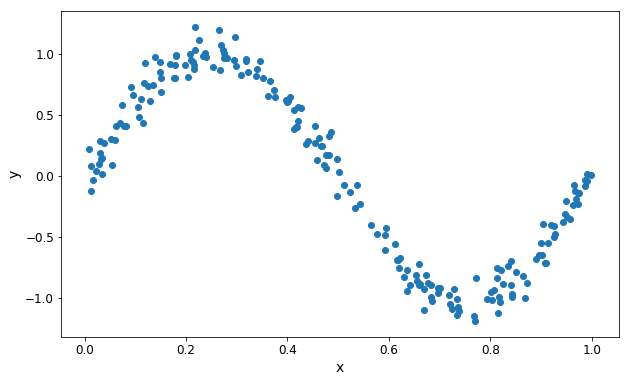

In [2]:
plt.figure(figsize=(10, 6))
plt.scatter(x_d, y_d)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.show()

Из каждого наблюдения $x_i$ построим вектор признаков $$\phi(x_i) = (1, x_i, x_i^2, ..., x_i^M)$$ и составим из векторов матрицу признаков $F$:

In [3]:
M = 20
F = np.vstack([x_d ** i for i in range(M + 1)]).T
F[:5, :5]

array([[1.00000000e+00, 6.12170176e-01, 3.74752324e-01, 2.29412196e-01,
        1.40439304e-01],
       [1.00000000e+00, 1.69069754e-01, 2.85845818e-02, 4.83278823e-03,
        8.17078319e-04],
       [1.00000000e+00, 4.36059019e-01, 1.90147468e-01, 8.29155186e-02,
        3.61560597e-02],
       [1.00000000e+00, 7.69262473e-01, 5.91764752e-01, 4.55222416e-01,
        3.50185521e-01],
       [1.00000000e+00, 2.95325304e-01, 8.72170354e-02, 2.57573975e-02,
        7.60681127e-03]])

Разделим датасет на 2 части, обучающую и тестовую, в соотношении 80:20:

In [4]:
F_train, F_test, y_train, y_test = train_test_split(F, y_d, test_size=0.2, random_state=42)

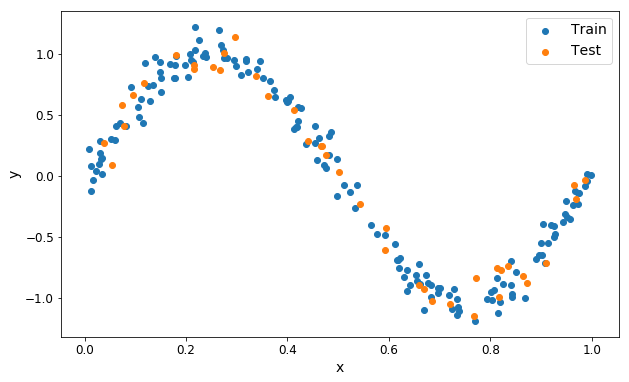

In [5]:
plt.figure(figsize=(10, 6))
plt.scatter(F_train[:, 1], y_train, label='Train')
plt.scatter(F_test[:, 1], y_test, label='Test')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.legend(fontsize=14)
plt.show()

## Модель

Зададим модель линейной регрессии: 
$$y|x, w, \beta \sim N(\phi w^T, \beta^2),$$
где $w=(w_0, w_1, ..., w^M)$. 

Для этой модели оценкой параметров $w$ по методу максимального правдоподобия (MLE) будет
$$w_{MLE} = (F^TF)^{-1}F^Ty_D^T.$$

Зафиксировав параметры $w=w_{MLE}$, наилучшей в среднеквадратичном ($l_2$) смысле оценкой для $y$ в новой точке $x$ будет 
$$\hat y(x) = \phi(x)w^T.$$

В нашем примере мы знаем порождающее распределение $p$, поэтому для любой оценки $\hat y(x)$ можем явно вычислить ошибку обобщения $L_p(\hat y)$ (generalization loss). В качестве функции потерь мы договаривались рассматривать $l_2$, поэтому $$L_p(\hat y) = E_p l_2(y, \hat y(x)) = E_p(y - \hat y(x))^2.$$

Для оценки $\hat y(x) = \phi(x)w^T$ дело сводится к вычислению интеграла
$$\int (y - \phi(x)w^T)^2 p(x, y) \rm dx \rm dy. $$

Используя подставляя конкретный вид для плотности $p$ и после некоторой алгебры, процедура расчета $L_p(\hat y)$ реализуется функцией `model_score`:

In [6]:
def model_score(w, s=0.1):
    def p(x, w, s):
        y = np.dot(x ** np.arange(len(w)), w)
        return np.sin(2 * np.pi * x) ** 2 + s ** 2 - 2 * np.sin(2 * np.pi * x) * y + y ** 2       
    return integrate.quad(lambda x: p(x, w, s), 0, 1)[0]

Посмотрим, каким будет качество моделей при различных $M$.

## Обучение

Для оценки параметров моделей будем использовать ```LinearRegression```  из библиотеки ```sklearn```. 

Построим модели с параметрами M = 1, 3, 20: 

In [7]:
reg_1 = LinearRegression(fit_intercept=False).fit(F_train[:, :2], y_train)
reg_3 = LinearRegression(fit_intercept=False).fit(F_train[:, :4], y_train)
reg_20 = LinearRegression(fit_intercept=False).fit(F_train[:, :21], y_train)

Сделаем `predict` по точкам $х$, равномерно разбивающим отрезок [-0.1, 1.1]:

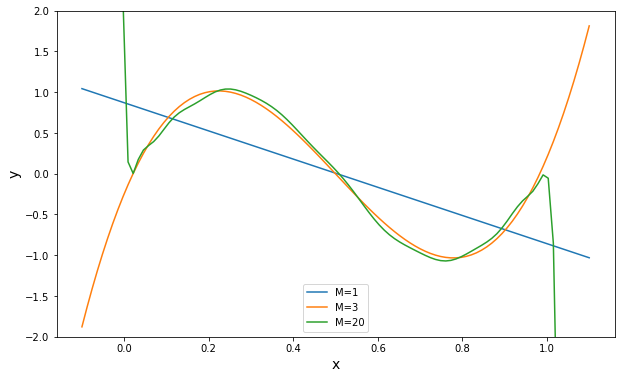

In [8]:
plt.figure(figsize=(10, 6))
x = np.linspace(-0.1, 1.1, 100).reshape(-1, 1)
plt.plot(x, reg_1.predict(x ** np.arange(2)), label='M=1')
plt.plot(x, reg_3.predict(x ** np.arange(4)), label='M=3')
plt.plot(x, reg_20.predict(x ** np.arange(21)), label='M=20')
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.legend(fontsize=14)
plt.legend()
plt.ylim(-2, 2)
plt.show()

Видно, что модель M=1 оказась слишком простой для описания данных, модель M=20 получилась "нефизичной", значит, истина где-то посередине.   

## Оценка модели

Исследуем количественно, как ведут себя 
* ошибка обучения (train loss)
* ошибка обобщения (generalization loss)
* ошибка на тестовом датасете (test loss)

при различных M.

Для сравнения изобразим также минимальную ошибку обобщнения для оптимальной модели. Зная $p$, несложно убедиться, что минимальной ошибкой будет $s^2$. Построить модель с ошибкой ниже этой нам не удастся.

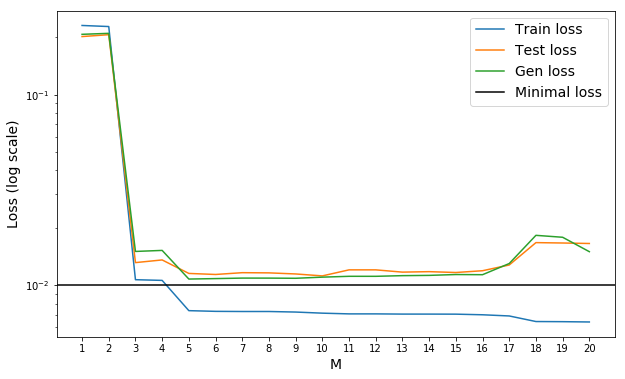

In [9]:
loss_train = []
loss_test = []
loss_model = []

M_MAX = 20
N_CLIP = 80

for m in range(1, M_MAX + 1):
    reg = LinearRegression(fit_intercept=False).fit(F_train[:N_CLIP, :m + 1], y_train[:N_CLIP])    
    loss_test.append(np.mean((reg.predict(F_test[:, :m + 1]) - y_test) ** 2))
    loss_train.append(np.mean((reg.predict(F_train[:N_CLIP, :m + 1]) - y_train[:N_CLIP]) ** 2))
    loss_model.append(model_score(reg.coef_))

plt.figure(figsize=(10, 6))
plt.semilogy(loss_train, label='Train loss')
plt.semilogy(loss_test, label='Test loss')
plt.semilogy(loss_model, label='Gen loss')
plt.axhline(s ** 2, color='black', label='Minimal loss')
plt.xlabel('M', fontsize=14)
plt.ylabel('Loss (log scale)', fontsize=14)
plt.xticks(np.arange(M), np.arange(1, M + 1))
plt.legend(fontsize=14)
plt.show()

Из графика можно сделать следующие выводы:
* тестовая выборка является оценкой для ошибки обобщения
* качество модели на обучающей выборке не является качеством модели в целом
* необходимо тестирование различных по сложности моделей для выбора оптимальной архитектуры.

## Влияние объема выборки

Теперь сравним, как ведет себя качество модели с увеличением объема выборки. Будем увеличивать объем выборки с шагом 5 для модели M=3:

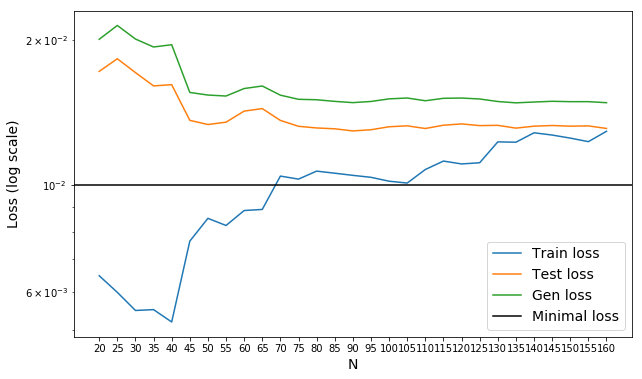

In [10]:
m = 3

loss_train = []
loss_test = []
loss_model = []

dataset_size = np.arange(20, len(F_train)+1, 5).astype(int)
for n in dataset_size:
    reg = LinearRegression(fit_intercept=False).fit(F_train[:n, :m + 1], y_train[:n])    
    loss_test.append(np.mean((reg.predict(F_test[:, :m + 1]) - y_test) ** 2))
    loss_train.append(np.mean((reg.predict(F_train[:n, :m + 1]) - y_train[:n]) ** 2))
    loss_model.append(model_score(reg.coef_))

plt.figure(figsize=(10, 6))
plt.semilogy(loss_train, label='Train loss')
plt.semilogy(loss_test, label='Test loss')
plt.semilogy(loss_model, label='Gen loss')
plt.axhline(s ** 2, color='black', label='Minimal loss')
plt.xlabel('N', fontsize=14)
plt.ylabel('Loss (log scale)', fontsize=14)
plt.xticks(np.arange(len(dataset_size)), dataset_size)
plt.legend(fontsize=14)
plt.show()

Видим, что ошибка обобщения и ошибка обучения сходятся к некоторой асимптоте, которая задается минимальной ошибкой модели. Разница между минимальной ошибкой модели и ошибкой оптимального прогноза характеризует безусловный bias модели. Для модели М=3 bias достаточно большой. К примеру, для модели М=7 минимальная ошибка лежит ближе к нижней границе:

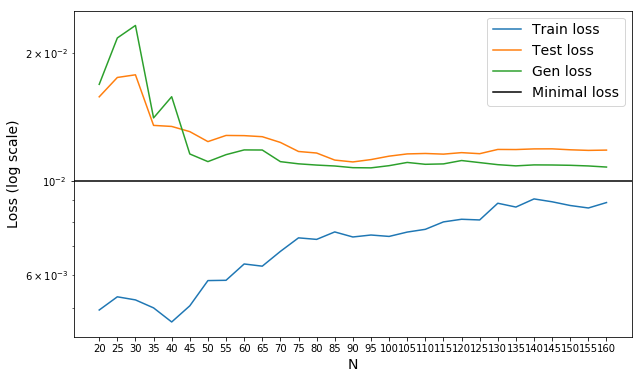

In [11]:
m = 7

loss_train = []
loss_test = []
loss_model = []

dataset_size = np.arange(20, len(F_train)+1, 5).astype(int)
for n in dataset_size:
    reg = LinearRegression(fit_intercept=False).fit(F_train[:n, :m + 1], y_train[:n])    
    loss_test.append(np.mean((reg.predict(F_test[:, :m + 1]) - y_test) ** 2))
    loss_train.append(np.mean((reg.predict(F_train[:n, :m + 1]) - y_train[:n]) ** 2))
    loss_model.append(model_score(reg.coef_))

plt.figure(figsize=(10, 6))
plt.semilogy(loss_train, label='Train loss')
plt.semilogy(loss_test, label='Test loss')
plt.semilogy(loss_model, label='Gen loss')
plt.axhline(s ** 2, color='black', label='Minimal loss')
plt.xlabel('N', fontsize=14)
plt.ylabel('Loss (log scale)', fontsize=14)
plt.xticks(np.arange(len(dataset_size)), dataset_size)
plt.legend(fontsize=14)
plt.show()

## Регуляризация 

Посмотрим, как выглядят коэффициенты модели при различных М.

In [12]:
m = 3
reg = LinearRegression(fit_intercept=False).fit(F_train[:, :m + 1], y_train)
reg.coef_

array([ -0.24597388,  12.48437763, -35.94744304,  23.90860474])

In [13]:
m = 7
reg = LinearRegression(fit_intercept=False).fit(F_train[:, :m + 1], y_train)
reg.coef_

array([-4.71206289e-02,  6.19295659e+00,  1.03813737e+01, -1.15702020e+02,
        2.16778168e+02, -2.04389975e+02,  1.26924436e+02, -4.01228784e+01])

In [14]:
m = 20
reg = LinearRegression(fit_intercept=False).fit(F_train[:, :m + 1], y_train)
reg.coef_

array([ 1.30428381e+00, -2.30023226e+02,  1.50438735e+04, -4.94824978e+05,
        9.85068982e+06, -1.29802338e+08,  1.19900047e+09, -8.07622104e+09,
        4.07903425e+10, -1.57557254e+11,  4.71769045e+11, -1.10430432e+12,
        2.02851475e+12, -2.92197820e+12,  3.28149210e+12, -2.83878622e+12,
        1.85295588e+12, -8.81812068e+11,  2.88494047e+11, -5.79709854e+10,
        5.39052861e+09])

Видим тенденцию: чем сложнее модель, тем больше разброс коэффициентов. 